In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.image import imread

plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 12})

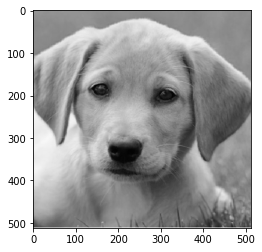

In [2]:
A = imread(os.path.join("data", "dog.jpg"))
plt.imshow(A[:,:,1], cmap="gray", vmin = 0, vmax = 255, interpolation = None)
plt.show()

## Exercise 1

In [3]:
U, S, VT = np.linalg.svd(A[:,:,1], full_matrices = True)

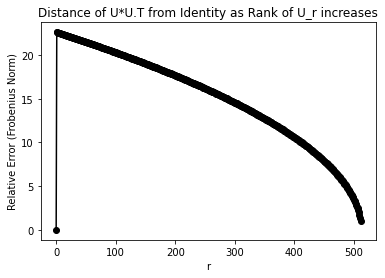

In [4]:
from plots import plot_distance_from_identity

plot_distance_from_identity(U, relative = False)

## Exercise 2

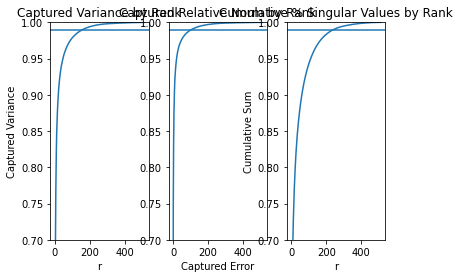

In [5]:
from plots import plot_reconstruction_metrics_vs_rank

plot_reconstruction_metrics_vs_rank(A[:,:,1])

## Exercise 3

In [6]:
content = loadmat(os.path.join("data", "allFaces.mat"))
faces = content['faces']
m = int(content['m'])
n = int(content['n'])
nfaces = np.ndarray.flatten(content['nfaces'])

In [7]:
trainingFaces = faces[:, : np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces, axis=1)

X = trainingFaces - np.tile(avgFace, (trainingFaces.shape[1], 1)).T

In [8]:
Ust, Sst, VTst = np.linalg.svd(X, full_matrices=False)

In [142]:
S, V = np.linalg.eigh(X.T @ X)
S2 = S  # Eigenvalues of covariance matrix
S = np.sqrt(S)  # Singular Values for Constructing U using the snapshot method
S2I = np.linalg.inv(np.diag(S2))  # Inverse Sigma Squared
SI = np.linalg.inv(np.diag(S)) # Inverse Sigma

# Remove singular values that are basically 0
idx = []
for i in range(np.diag(S).shape[1]):
    if np.any(SI[:, i-1] > 1000):
        idx.append(i-1)
SI = np.delete(SI, idx, axis=0)
S2I = np.delete(S2I, idx, axis=0)
V = np.delete(V, idx, axis=1)

# Compute U approximation
U = X @ (V @ SI)
U_strange = X @ (V @ S2I)

# Sort by magnitude of corresponding singular values
sort_idx = np.argsort(S)[::-1]
sort_idx2 = np.argsort(S2)[::-1]
sort_idx3 = np.argsort(np.delete(S, idx, axis=0))[::-1]

In [143]:
S = np.sort(S)[::-1]
S2 = np.sort(S2)[::-1]
U = U[:, sort_idx]
U_strange = U_strange[:, sort_idx2]
V = V[:, sort_idx3]

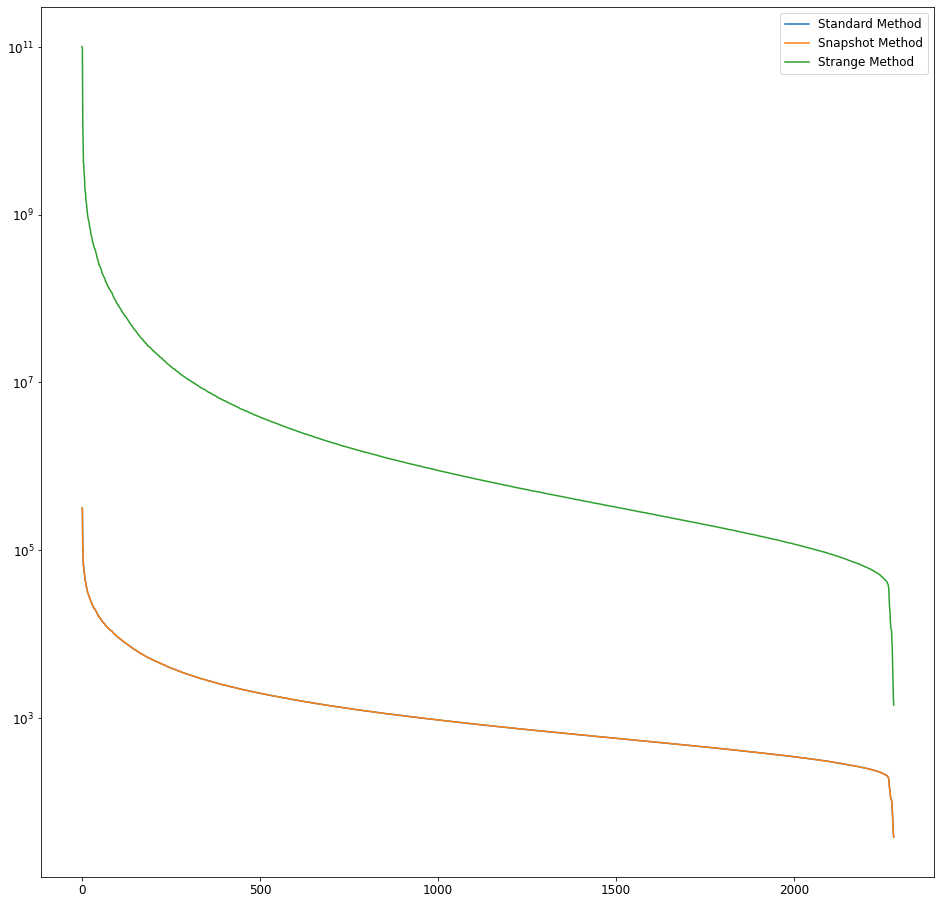

In [144]:
plt.semilogy(np.delete(Sst, -1, axis=0), label="Standard Method")
plt.semilogy(np.delete(S, -1, axis=0), label="Snapshot Method")
plt.semilogy(np.delete(S2, -1, axis=0), label="Strange Method")
plt.legend()
plt.show()

In [145]:
testFace = faces[:, np.sum(nfaces[:36])]
testFaceMS = testFace - avgFace
reconFace_std = Ust[:, :10] @ Ust[:, :10].T @ testFaceMS
reconFace_snap = U[:, :10] @ U[:, :10].T @ testFaceMS
reconFace_strange = U_strange[:, :10] @ U_strange[:, :10].T @ testFaceMS

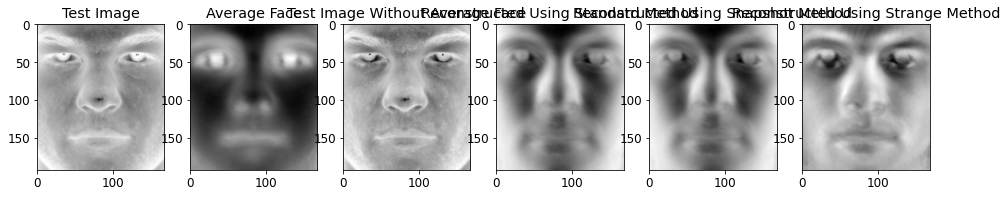

In [146]:
fig, ax = plt.subplots(nrows=1, ncols=6)
ax[0].imshow(1 - np.reshape(testFace, (m, n)).T, cmap="gray")
ax[0].set_title("Test Image")
ax[1].imshow(1 - np.reshape(avgFace, (m, n)).T, cmap="gray")
ax[1].set_title("Average Face")
ax[2].imshow(1 - np.reshape(testFaceMS, (m, n)).T, cmap="gray")
ax[2].set_title("Test Image Without Average Face")
ax[3].imshow(1 - np.reshape(reconFace_std, (m,n)).T, cmap="gray")
ax[3].set_title("Reconstructed Using Standard Method")
ax[4].imshow(1 - np.reshape(reconFace_snap, (m, n)).T, cmap="gray")
ax[4].set_title("Reconstructed Using Snapshot Method")
ax[5].imshow(1 - np.reshape(reconFace_strange, (m, n)).T, cmap="gray")
ax[5].set_title("Reconstructed Using Strange Method")
plt.show()

In [151]:
reconFace2_std = Ust[:, 11:21] @ Ust[:, 11:21].T @ testFaceMS
reconFace2_snap = U[:, 11:21] @ U[:, 11:21].T @ testFaceMS
reconFace2_strange = U_strange[:, 11:21] @ U_strange[:, 11:21].T @ testFaceMS

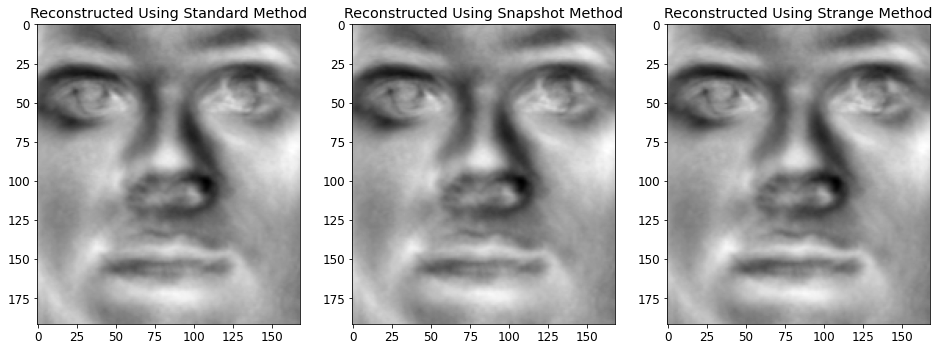

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(1 - np.reshape(reconFace2_std, (m, n)).T, cmap="gray")
ax[0].set_title("Reconstructed Using Standard Method")
ax[1].imshow(1 - np.reshape(reconFace2_snap, (m, n)).T, cmap="gray")
ax[1].set_title("Reconstructed Using Snapshot Method")
ax[2].imshow(1 - np.reshape(reconFace2_strange, (m, n)).T, cmap="gray")
ax[2].set_title("Reconstructed Using Strange Method")
plt.show()

In [154]:
reconFace3_std = Ust[:, :400] @ Ust[:, :400].T @ testFaceMS
reconFace3_snap = U[:, :400] @ U[:, :400].T @ testFaceMS
reconFace3_strange = U_strange[:, :400] @ U_strange[:, :400].T @ testFaceMS

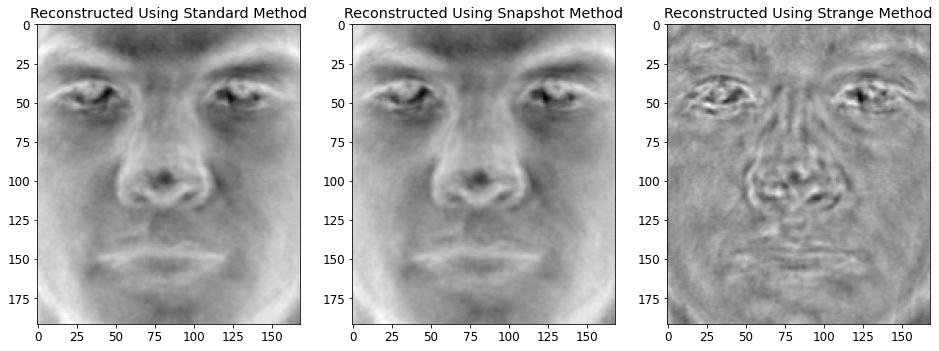

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(1 - np.reshape(reconFace3_std, (m,n)).T, cmap="gray")
ax[0].set_title("Reconstructed Using Standard Method")
ax[1].imshow(1 - np.reshape(reconFace3_snap, (m, n)).T, cmap="gray")
ax[1].set_title("Reconstructed Using Snapshot Method")
ax[2].imshow(1 - np.reshape(reconFace3_strange, (m, n)).T, cmap="gray")
ax[2].set_title("Reconstructed Using Strange Method")

plt.show()

The reconstructions are indistinguishable. Just remember to square root the eigenvalues you obtain from the eigendecomposition and you won't make a silly mistake like me! What I found really interesting was that the low-rank reconstructions were seemingly better when I accidentally used the eigenvalues from the eigendecomposition of X^T * X instead of the singular values that we obtain from an element-wise square root of sigma across the diagonal. The "better" appearance of the lower rank approximation from the strange method could just be a consequence of the picture being darker (as I would expect from squaring sigma). I don't see anything noticeably different from the other reconstructions other than the darkness.

## Exercise 4